# Expression Trees in PyMC

Expression trees, also known as factorable functions, can be represented using __directed acyclic graphs (DAGs)__, whose nodes are subexpressions and whose directed edges are computational flows ([Schichl & Neumaier, 2005](http://dx.doi.org/10.1007/s10898-005-0937-x)). A key advantage of DAGs is that they can handle common subexpressions shared by several functions effectively.

An implementation of DAGs for factorable functions is provided through MC++. Capability includes __DAG evaluation__ in a range of arithmetics supported by MC++, including interval ranges, McCormick relaxations, Taylor and Chebyshev models, spectral bounds, interval superposition models, and polyhedral relaxations. Other capability includes their symbolic manipulation, including __automatic differentiation__. PyMC provides a python interface to these classes.

## Defining an Expression Tree in PyMC

Suppose we want to construct a DAG for the factorable function ${\bf f}:\mathbb{R}^4\to\mathbb{R}^2$ defined by
$${\bf f}(x_0,x_1,x_2,x_3) = \left(\begin{array}{c} x_2x_3-x_0\\ x_0\sqrt{\exp(x_2x_3)+1}+x_1\end{array}\right)$$

We start by importing the PyMC library:

In [1]:
import pymc

An environment `FFGraph` is first defined for recording the DAG of the function:

In [2]:
DAG = pymc.FFGraph()

All four variables participating in the function are then defined in the DAG environment using the type `FFVar`:

In [3]:
NX = 4
X = []
for i in range(NX):
    X.append( pymc.FFVar(DAG,"X"+str(i)) )

In [4]:
F = [ X[2]*X[3]-X[0], X[0]*pymc.sqrt(pymc.exp(X[2]*X[3])+1)+X[1] ]

The entire DAG so far can be displayed as follows:

In [5]:
print(DAG)


DAG VARIABLES:
  X0	 => { Z1 Z6 }
  X1	 => { Z7 }
  X2	 => { Z0 }
  X3	 => { Z0 }

DAG INTERMEDIATES:
  Z0	<=  X2 x X3		 => { Z1 Z2 }
  Z1	<=  Z0 - X0		 => { }
  Z2	<=  EXP( Z0 )		 => { Z4 }
  Z4	<=  Z2 + Z3		 => { Z5 }
  Z5	<=  SQRT( Z4 )		 => { Z6 }
  Z6	<=  X0 x Z5		 => { Z7 }
  Z7	<=  X1 + Z6		 => { }
  Z3	<=  1(I)		 => { Z4 }



Observe that 9 auxiliary variables $z_0,\ldots,z_8$ have been created in the DAG, which correspond to the various unary and binary operations in the factorable function expression, as well as the (integer or real) participating constants. Also note that the common sub-expression $x_2x_3$ is detected here; that is, the intermediate $z_0$ is reused to obtain both subsequent auxiliary variables $z_1$ and $z_2$.

Subgraphs of the DAG corresponding to selected dependent variables can be generated and displayed:

In [6]:
F[0].set("F0")
F[1].set("F1")
sgF = DAG.subgraph( F )
DAG.output( sgF, " F" )


OPERATIONS IN SUBGRAPH F:
  X2	<<  VARIABLE
  X3	<<  VARIABLE
  Z0	<-  X2 x X3	
  X0	<-  VARIABLE
  F0	<<  Z0 - X0	
  X1	<<  VARIABLE
  Z2	<<  EXP( Z0 )	
  Z3	<<  1(I)	
  Z4	<<  Z2 + Z3	
  Z5	<<  SQRT( Z4 )	
  Z6	<<  X0 x Z5	
  F1	<<  X1 + Z6	
DEPENDENTS IN SUBGRAPH F:
  0:  F0
  1:  F1
WORK ARRAY SIZE: 12


One-line string expressions can also be generated for DAG variables using the `str` field:

In [7]:
print( F[0], " = ", F[0].str() )
print( F[1], " = ", F[1].str() )

F0  =  X2 * X3 - X0
F1  =  X1 + X0 * SQRT( EXP( X2 * X3 ) + 1 )


Subgraphs may also be depicted using [Graphviz](http://www.graphviz.org/). For instance, the dot file `F.dot` for the function dependents `F` can be generated as follows:

In [8]:
DAG.dot_script( F, "F.dot" )

Such dot files may be converted into image files using [PyGraphviz](https://pygraphviz.github.io/documentation/stable/index.html):

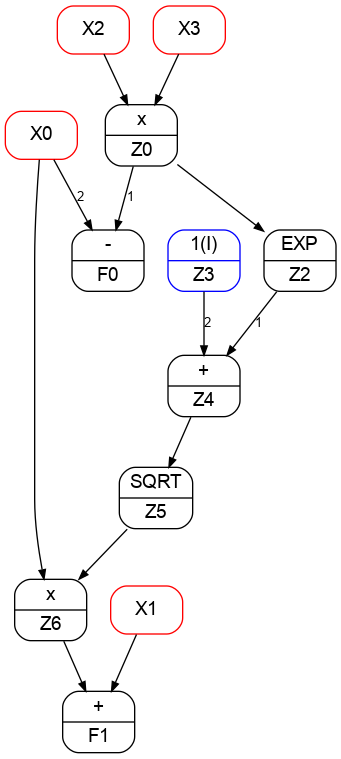

In [9]:
import pygraphviz as pgv
G = pgv.AGraph("F.dot")
G.draw("F.png", prog="dot")

from IPython.display import Image
fig = Image(filename=('F.png'))
fig

## Differenting an Expression Tree in PyMC

Symbolic differentiation in PyMC implements both the forward and reverse modes of automatic differentiation, available through the methods `fdiff` and `bdiff`, respectively. Derivatives are provided in sparse format (triplet of row indices, column indices and derivative entries in lists).

### Sparse Derivatives

For instance, sparse derivatives of the two-component function $f$ with respect to the four variables $x_0,\ldots,x_3$ using the reverse mode are computed as:

In [10]:
[Row,Col,dFdX] = DAG.bdiff( F, X )
print( Row, Col, dFdX )

[0, 0, 0, 1, 1, 1, 1] [0, 2, 3, 0, 1, 2, 3] [Z11, X3, X2, Z5, Z3, Z15, Z14]


A subgraph of the derivative $\displaystyle\frac{\partial f_1}{\partial x_0} = \sqrt{\exp(x_2x_3)+1}$ is given by: 

In [11]:
print( dFdX[3], " = ", dFdX[3].str() )
DAG.output( [dFdX[3]], " dF1/dX0" )

Z5  =  SQRT( EXP( X2 * X3 ) + 1 )

OPERATIONS IN SUBGRAPH dF1/dX0:
  X2	<<  VARIABLE
  X3	<<  VARIABLE
  Z0	<<  X2 x X3	
  Z2	<<  EXP( Z0 )	
  Z3	<<  1(I)	
  Z4	<<  Z2 + Z3	
  Z5	<<  SQRT( Z4 )	
DEPENDENTS IN SUBGRAPH dF1/dX0:
  0:  Z5
WORK ARRAY SIZE: 7


Differentiation can be chained to compute second- and higher-order derivatives. For instance, the second-order derivatives (Hessian) of $f_1$ with respect to $x_0,\ldots,x_3$ using a combination of reverse and forward differentiation are obtained as:

In [12]:
[Row1,Col1,dF1dX]   = DAG.bdiff( [F[1]], X )
[Row2,Col2,d2F1dX2] = DAG.fdiff( dF1dX, X )
print( [Col1[i] for i in Row2], Col2, d2F1dX2 )

[2, 3, 0, 2, 3, 0, 2, 3] [0, 0, 2, 2, 2, 3, 3, 3] [Z19, Z20, Z22, Z29, Z31, Z33, Z41, Z42]


Subgraph of the second-order derivatives $\displaystyle\frac{\partial^2 f_1}{\partial x_2\partial x_0} = \displaystyle\frac{\partial^2 f_1}{\partial x_0\partial x_2} = \frac{x_3\exp(x_2x_3)}{2\sqrt{\exp(x_2x_3)+1}}$ are given by: 

In [13]:
print( d2F1dX2[0], " = ", d2F1dX2[0].str() )
print( d2F1dX2[2], " = ", d2F1dX2[2].str() )

Z19  =  X3 * EXP( X2 * X3 ) * ( 1 / SQRT( EXP( X2 * X3 ) + 1 ) ) * 0.5
Z22  =  ( ( 1 / SQRT( EXP( X2 * X3 ) + 1 ) ) * 0.5 ) * X3 * EXP( X2 * X3 )


Notice, in particular, how the subgraphs of the $\displaystyle\frac{\partial^2 f_1}{\partial x_2\partial x_0}$ and $\displaystyle\frac{\partial^2 f_1}{\partial x_0\partial x_2}$ are different but yield two equivalent representations of the same expression.

### Directional Derivatives

Similarly, directional derivatives of the function $f_1$ with respect to $(x_0,\ldots,x_3)$ in a direction $(d_0,\ldots,d_4)$ are computed using the forward mode as:

In [14]:
D = []
for i in range(NX):
    D.append( pymc.FFVar(DAG,"D"+str(i)) )
[Row,Col,dF1dX_D] = DAG.fdiff( [F[1]], X, D )

A subgraph of the directional derivative $\displaystyle\frac{\partial f_1}{\partial x}\cdot d = \sum_i \frac{\partial f_1}{\partial x_i} d_i$ is given by:

In [15]:
print( "dF1/dX·D = ", dF1dX_D[0].str() )

dF1/dX·D =  D1 + D0 * SQRT( EXP( X2 * X3 ) + 1 ) + X0 * ( ( 1 / SQRT( EXP( X2 * X3 ) + 1 ) ) * 0.5 ) * EXP( X2 * X3 ) * ( X3 * D2 + X2 * D3 )


Finally, directional derivatives of the two-component function $f$ with respect to $x_0$ in a direction $(d_0,d_1)$ are computed using the reverse mode as:

In [16]:
[Row,Col,D_dFdX0] = DAG.bdiff( F, [D[0],D[1]], [X[0]] )

A subgraph of the directional derivative $d\cdot \displaystyle\frac{\partial f}{\partial x_0} = \sum_i d_i\frac{\partial f_i}{\partial x_0}$ is given by:

In [17]:
print( "D·dF/dX0 = ", D_dFdX0[0].str() )

D·dF/dX0 =  ( - D0 ) + D1 * SQRT( EXP( X2 * X3 ) + 1 )


## Evaluating an Expression Tree in PyMC

One of the main benefits of defining expression trees in pyMC is of course the ability to evaluate a DAG in various arithmetics.

For instance, the values of $(f_0,f_1)$ and $\displaystyle\frac{\partial^2 f_1}{\partial x_2\partial x_0}$ at $(x_0,x_1,x_2,x_3)=(1,0.5,-1,2)$ are computed as:

In [18]:
DF = DAG.eval( F, X, [1,0.5,-1,2] )
print(DF)

Dd2F1dX0dX2 = DAG.eval( [d2F1dX2[2]], X, [1,0.5,-1,2] )
print(Dd2F1dX0dX2)

[-3.0, 1.5655211322337126]
[0.12701323243857365]


Instead, if one whishes to compute bounds on the range of $(f_0,f_1)$ and $\displaystyle\frac{\partial^2 f_1}{\partial x_2\partial x_0}$ for $(x_0,x_1,x_2,x_3)\in [0.9,1.1]\times[0.4,0.6]\times[-0.5,1.5]\times[1.8,2.3]$, the DAGs can be evaluated in interval arithmetic:

In [19]:
IX = [pymc.Interval(0.9,1.1),pymc.Interval(0.4,0.6),pymc.Interval(-1.5,-0.5),pymc.Interval(1.8,2.3)]

IF = DAG.eval( F, X, IX )
print(IF)

Id2F1dX0dX2 = DAG.eval( [d2F1dX2[2]], X, IX )
print(Id2F1dX0dX2)

[[ -4.55000e+00 : -1.80000e+00 ], [  1.31417e+00 :  1.90459e+00 ]]
[[  2.40905e-02 :  4.60306e-01 ]]


pyMC also has built-in capability for evaluation a DAG at multiple points. For a great many points, these evaluations may be performed in parallel by dispatching on multiple threads (vectorization). The maximal number of threads is controlled by the option `MAXTHREAD` of a DAG.



In [20]:
from scipy.stats import qmc
sampler = qmc.Sobol(d=NX, scramble=False)
samX = sampler.random_base2(m=20) # 2^20~10^6 evaluations 
#print(samX.tolist())

DAG.options.MAXTHREAD = 1
samF = DAG.veval( F, X, samX.tolist(), walltime=True )
#print(samF)

DAG.options.MAXTHREAD = 2
samF = DAG.veval( F, X, samX.tolist(), walltime=True )

DAG.options.MAXTHREAD = 3
samF = DAG.veval( F, X, samX.tolist(), walltime=True )

DAG.options.MAXTHREAD = 0 # all available threads
samF = DAG.veval( F, X, samX.tolist(), walltime=True )

vectorized DAG evaluation on 1 threads: 0.101075 sec
vectorized DAG evaluation on 2 threads: 0.074463 sec
vectorized DAG evaluation on 3 threads: 0.049482 sec
vectorized DAG evaluation on 0 threads: 0.035135 sec


In [21]:
import numpy as np
import time

start = time.time()
samF = [ samX[:,2]*samX[:,3]-samX[:,0], samX[:,0]*np.sqrt(np.exp(samX[:,2]*samX[:,3])+1)+samX[:,1] ]
end = time.time()
print("eval walltime with numpy: ", end - start)

eval walltime with numpy:  0.05153226852416992
